# Sentinel 5P NO2 Data Processing Pipeline #2A

In [31]:
from s5p_no2_tools import sentinel_api_query, date_from_week, add_days, \
    download_nc_file, geometry_to_wkt, filter_swath_set, create_project, get_place_boundingbox

import pandas as pd

## Design of Pipeline 2

Pipeline 2 is designed to be able to complete remote sensing projects in 4 Pipeline 2 Notebooks. An NO2 remote sensing project in this context is defined as place-based remote sensing studies of NO2 levels using multiweek data from the Sentinel 5P mission. 

The project is stored in the `project` folder. The working directory for each project is defined as `project/{place name}`. The week list is defined using a list called `week_list`. Each element of this list is in the form `YYYY-Wnn`, where `YYYY` is the calendar year and `nn` in `Wnn` is the week number based on the calendar year (01-52). 

In Pipeline 2A, we will:
1. Create a list of comparable weeks from 2019 and 2020 and use this to download satellite data
2. Construct the query dictionary containing parameters to pass to the Sentinel 5P Data Access Hub API
3. Download satellite data as NetCD4 files using this query dictionary from the Sentinel 5P Data Access Hub

## Step 1: Create Project

In [32]:
project_name='projects/thailand'
working_directory = create_project(project_name)

working_directory

Directory projects/thailand exists.


'projects/thailand'

## Step 2: Create list of weeks to download

In [33]:
week_list = ['2019-W01','2019-W06','2019-W11','2019-W17','2020-W01','2020-W06','2020-W11','2020-W17']

## Step 3: Create WKT string for query polygon

The shape files for place are stored in the `data` subfolder. The data sources for these Pipeline 2 notebooks are downloaded from the GADM web site using the [`NB01-Data-Sources`](./NB01-Data-Sources.ipynb) notebook. The shapefiles from the GADM website are found in the `gadm36` subfolder. The place under study could be a country, province or city.

In [34]:
asia0_gdf = pd.read_pickle('data/asia0_gdf.pickle')
thailand0 = asia0_gdf[asia0_gdf['name']=='Thailand']

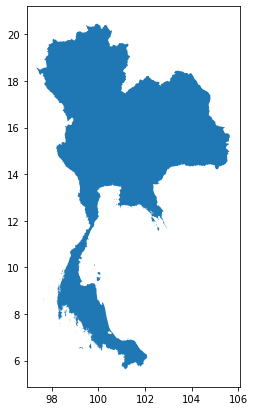

In [35]:
thailand0.plot(figsize=(10,7))

### Create bounding box

In [36]:
import geopandas as gpd

place0 = thailand0
bbox = get_place_boundingbox(place_gdf=place0, buffer=0.5)
bbox.to_pickle(working_directory+'/bbox_gdf.pickle')

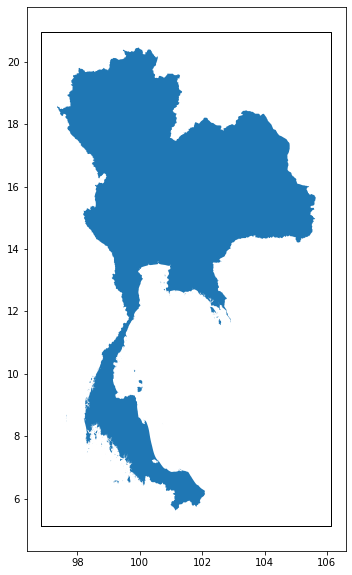

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (16,10)) 
place0.plot(ax=ax)
bbox.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax)

In [38]:
polygon = geometry_to_wkt(place_gdf=bbox)

polygon

'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))'

## Step 4: Compose the API query and send query for each week in the week list

You do not need to change anything below for a standard project.

In [42]:
%%time
productType='L2__NO2___'
processingLevel='L2'
platformName='Sentinel-5'
processingMode='Offline'
startPage=0
numRows=50
dhus_url='https://s5phub.copernicus.eu/'
username='s5pguest'
password='s5pguest'
days_period=21

gdf_list = []
swath_stats_df = pd.DataFrame()
for i in range(0,len(week_list)):
    tic = time.perf_counter()
    print('==================================')
    print(week_list[i])
    gdf_name = week_list[i]+'_gdf'
    startDate, endDate = add_days(start=date_from_week(weekstring=week_list[i]),numDays=days_period)
    query_dict = {
        'startDate': startDate,
        'endDate': endDate,
        'productType': productType,
        'processingLevel': processingLevel,
        'platformName': platformName,
        'processingMode': processingMode,
        'polygon': polygon,
        'startPage': startPage,
        'numRows': numRows,
        'dhus_url': dhus_url,
        'username': username,
        'password': password
    }
    print(query_dict)
    
    query_gdf = sentinel_api_query(query_dict, silentmode=True)
    
    query_rows = len(query_gdf)
    print('query_gdf records:', query_rows)
    query_gdf.crs = place0.crs
    sjoin_gdf = filter_swath_set(swath_set_gdf = query_gdf, place_gdf=bbox)
    sjoin_gdf = sjoin_gdf.reset_index()
    filtered_rows = len(sjoin_gdf)
    print('sjoin_gdf records:', filtered_rows)
    toc = time.perf_counter()
    elapsed_time = toc-tic
    print("Processed "+week_list[i]+" in "+str(elapsed_time)+" seconds")

    swath_stats_dict = {'week': week_list[i], 'query_rows': query_rows, \
                        'filtered_rows':filtered_rows,'elapsed_time_sec': elapsed_time}
    swath_stats_df = swath_stats_df.append([swath_stats_dict], ignore_index=True)
    gdf_list.append(sjoin_gdf)
    sjoin_gdf.to_pickle(working_directory+'/gdf-'+week_list[i]+'.pickle')
swath_stats_df.to_pickle(working_directory+'/swath_stats_df.pickle')

2019-W01
{'startDate': '2019-01-07', 'endDate': '2019-01-28', 'productType': 'L2__NO2___', 'processingLevel': 'L2', 'platformName': 'Sentinel-5', 'processingMode': 'Offline', 'polygon': 'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))', 'startPage': 0, 'numRows': 50, 'dhus_url': 'https://s5phub.copernicus.eu/', 'username': 's5pguest', 'password': 's5pguest'}
OrderedDict([('title', 'S5P_OFFL_L2__NO2____20190128T063701_20190128T081831_06695_01_010202_20190203T085408'), ('link', [OrderedDict([('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('a7b921f9-a237-4ba6-9969-2ef79a01868d')/$value")]), OrderedDict([('@rel', 'alternative'), ('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('a7b921f9-a237-4ba6-9969-2ef79a01868d')/")]), OrderedDict([('@rel', 'icon'), ('@href', "https://s5phub.copernicus.eu/dhus/

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


query_gdf records: 36
sjoin_gdf records: 11
Processed 2019-W01 in 7.863485072739422 seconds
2019-W06
{'startDate': '2019-02-11', 'endDate': '2019-03-04', 'productType': 'L2__NO2___', 'processingLevel': 'L2', 'platformName': 'Sentinel-5', 'processingMode': 'Offline', 'polygon': 'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))', 'startPage': 0, 'numRows': 50, 'dhus_url': 'https://s5phub.copernicus.eu/', 'username': 's5pguest', 'password': 's5pguest'}
OrderedDict([('title', 'S5P_OFFL_L2__NO2____20190304T054319_20190304T072449_07191_01_010202_20190310T073637'), ('link', [OrderedDict([('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('c846e3e6-60a0-42fc-9dd3-23970faa6c33')/$value")]), OrderedDict([('@rel', 'alternative'), ('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('c846e3e6-60a0-42fc-9dd3-23970

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


query_gdf records: 36
sjoin_gdf records: 12
Processed 2019-W06 in 5.722339538857341 seconds
2019-W11
{'startDate': '2019-03-18', 'endDate': '2019-04-08', 'productType': 'L2__NO2___', 'processingLevel': 'L2', 'platformName': 'Sentinel-5', 'processingMode': 'Offline', 'polygon': 'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))', 'startPage': 0, 'numRows': 50, 'dhus_url': 'https://s5phub.copernicus.eu/', 'username': 's5pguest', 'password': 's5pguest'}
OrderedDict([('title', 'S5P_OFFL_L2__NO2____20190408T045012_20190408T063143_07687_01_010300_20190414T064153'), ('link', [OrderedDict([('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('a344fdf8-e1f9-4c0e-bc38-b6cba6873dc9')/$value")]), OrderedDict([('@rel', 'alternative'), ('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('a344fdf8-e1f9-4c0e-bc38-b6cba

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


query_gdf records: 36
sjoin_gdf records: 11
Processed 2019-W11 in 24.908372519537807 seconds
2019-W17
{'startDate': '2019-04-29', 'endDate': '2019-05-20', 'productType': 'L2__NO2___', 'processingLevel': 'L2', 'platformName': 'Sentinel-5', 'processingMode': 'Offline', 'polygon': 'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))', 'startPage': 0, 'numRows': 50, 'dhus_url': 'https://s5phub.copernicus.eu/', 'username': 's5pguest', 'password': 's5pguest'}
OrderedDict([('title', 'S5P_OFFL_L2__NO2____20190519T070653_20190519T084823_08270_01_010301_20190525T092126'), ('link', [OrderedDict([('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('2d69bed5-a3b2-4a63-a591-3017c6e0f7ca')/$value")]), OrderedDict([('@rel', 'alternative'), ('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('2d69bed5-a3b2-4a63-a591-3017

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


query_gdf records: 35
sjoin_gdf records: 11
Processed 2019-W17 in 5.973565719090402 seconds
2020-W01
{'startDate': '2020-01-06', 'endDate': '2020-01-27', 'productType': 'L2__NO2___', 'processingLevel': 'L2', 'platformName': 'Sentinel-5', 'processingMode': 'Offline', 'polygon': 'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))', 'startPage': 0, 'numRows': 50, 'dhus_url': 'https://s5phub.copernicus.eu/', 'username': 's5pguest', 'password': 's5pguest'}
OrderedDict([('title', 'S5P_OFFL_L2__NO2____20200127T061120_20200127T075250_11859_01_010302_20200130T110815'), ('link', [OrderedDict([('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('b00338fa-8704-4eb9-90d8-32db4bc9711b')/$value")]), OrderedDict([('@rel', 'alternative'), ('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('b00338fa-8704-4eb9-90d8-32db4

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


query_gdf records: 36
sjoin_gdf records: 10
Processed 2020-W01 in 8.925815789029002 seconds
2020-W06
{'startDate': '2020-02-10', 'endDate': '2020-03-02', 'productType': 'L2__NO2___', 'processingLevel': 'L2', 'platformName': 'Sentinel-5', 'processingMode': 'Offline', 'polygon': 'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))', 'startPage': 0, 'numRows': 50, 'dhus_url': 'https://s5phub.copernicus.eu/', 'username': 's5pguest', 'password': 's5pguest'}
OrderedDict([('title', 'S5P_OFFL_L2__NO2____20200302T051743_20200302T065913_12355_01_010302_20200305T102836'), ('link', [OrderedDict([('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('27185aab-56f2-454c-8c59-c1ed9a4407c9')/$value")]), OrderedDict([('@rel', 'alternative'), ('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('27185aab-56f2-454c-8c59-c1ed9

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


query_gdf records: 36
sjoin_gdf records: 11
Processed 2020-W06 in 17.037980249151587 seconds
2020-W11
{'startDate': '2020-03-16', 'endDate': '2020-04-06', 'productType': 'L2__NO2___', 'processingLevel': 'L2', 'platformName': 'Sentinel-5', 'processingMode': 'Offline', 'polygon': 'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))', 'startPage': 0, 'numRows': 50, 'dhus_url': 'https://s5phub.copernicus.eu/', 'username': 's5pguest', 'password': 's5pguest'}
OrderedDict([('title', 'S5P_OFFL_L2__NO2____20200403T070259_20200403T084430_12810_01_010302_20200414T213449'), ('link', [OrderedDict([('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('c36371ca-473a-483d-aafe-084460fabcc2')/$value")]), OrderedDict([('@rel', 'alternative'), ('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('c36371ca-473a-483d-aafe-0844

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


query_gdf records: 35
sjoin_gdf records: 12
Processed 2020-W11 in 11.929341248236597 seconds
2020-W17
{'startDate': '2020-04-27', 'endDate': '2020-05-18', 'productType': 'L2__NO2___', 'processingLevel': 'L2', 'platformName': 'Sentinel-5', 'processingMode': 'Offline', 'polygon': 'POLYGON ((96.8454452170056186 5.1160725796399271, 96.8454452170056186 20.9632107773196630, 106.1386020856645160 20.9632107773196630, 106.1386020856645160 5.1160725796399271, 96.8454452170056186 5.1160725796399271))', 'startPage': 0, 'numRows': 50, 'dhus_url': 'https://s5phub.copernicus.eu/', 'username': 's5pguest', 'password': 's5pguest'}
OrderedDict([('title', 'S5P_OFFL_L2__NO2____20200518T044109_20200518T062239_13447_01_010302_20200519T212651'), ('link', [OrderedDict([('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('60be235c-f0d2-424c-9e09-7da77c4181f4')/$value")]), OrderedDict([('@rel', 'alternative'), ('@href', "https://s5phub.copernicus.eu/dhus/odata/v1/Products('60be235c-f0d2-424c-9e09-7da7

query_gdf records: 36
sjoin_gdf records: 10
Processed 2020-W17 in 24.9318719021976 seconds
CPU times: user 2.85 s, sys: 52.8 ms, total: 2.9 s
Wall time: 1min 47s


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [44]:
swath_stats_df['filter_rate'] = swath_stats_df['filtered_rows']/swath_stats_df['query_rows']
swath_stats_df

week  query_rows  filtered_rows  elapsed_time_sec  filter_rate
0  2019-W01          36             11          7.863485     0.305556
1  2019-W06          36             12          5.722340     0.333333
2  2019-W11          36             11         24.908373     0.305556
3  2019-W17          35             11          5.973566     0.314286
4  2020-W01          36             10          8.925816     0.277778
5  2020-W06          36             11         17.037980     0.305556
6  2020-W11          35             12         11.929341     0.342857
7  2020-W17          36             10         24.931872     0.277778

In [47]:
swath_stats_df['filter_rate'].mean()

0.3078373015873016

In [45]:
len(gdf_list)

8

In [46]:
gdf_list[0]

index       beginposition        crs  \
0       0 2019-01-16 05:41:41  epsg:4326   
1       1 2019-01-15 06:00:39  epsg:4326   
2       2 2019-01-14 06:19:38  epsg:4326   
3       3 2019-01-11 05:35:04  epsg:4326   
4       4 2019-01-10 05:54:04  epsg:4326   
5       5 2019-01-09 06:13:03  epsg:4326   
6       6 2019-01-27 05:36:02  epsg:4326   
7       7 2019-01-26 05:55:00  epsg:4326   
8       8 2019-01-25 06:13:58  epsg:4326   
9       9 2019-01-20 06:07:17  epsg:4326   
10     10 2019-01-21 05:48:18  epsg:4326   

                                          downloadurl         endposition  \
0   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-16 06:40:04   
1   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-15 06:59:03   
2   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-14 07:18:01   
3   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-11 06:33:28   
4   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-10 06:46:21   
5   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-09 07:11:27   
6   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-27 06:34:25   
7   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-26 06:53:23   
8   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-25 07:12:21   
9   https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-20 07:05:40   
10  https://s5phub.copernicus.eu/dhus/odata/v1/Pro... 2019-01-21 06:46:42   

                                             filename  \
0   S5P_OFFL_L2__NO2____20190116T052006_20190116T0...   
1   S5P_OFFL_L2__NO2____20190115T053905_20190115T0...   
2   S5P_OFFL_L2__NO2____20190114T055803_20190114T0...   
3   S5P_OFFL_L2__NO2____20190111T051330_20190111T0...   
4   S5P_OFFL_L2__NO2____20190110T053230_20190110T0...   
5   S5P_OFFL_L2__NO2____20190109T055129_20190109T0...   
6   S5P_OFFL_L2__NO2____20190127T051428_20190127T0...   
7   S5P_OFFL_L2__NO2____20190126T053325_20190126T0...   
8   S5P_OFFL_L2__NO2____20190125T055223_20190125T0...   
9   S5P_OFFL_L2__NO2____20190120T054542_20190120T0...   
10  S5P_OFFL_L2__NO2____20190121T052644_20190121T0...   

                                            footprint  format  \
0   MULTIPOLYGON (((-180 -85.05115, -11.3853749188...  netCDF   
1   MULTIPOLYGON (((-180 -85.05115, -15.3463509207...  netCDF   
2   MULTIPOLYGON (((-180 -85.05115, -19.5138567628...  netCDF   
3   MULTIPOLYGON (((-180 -85.05115, -8.06024833292...  netCDF   
4   MULTIPOLYGON (((-180 -85.05115, -13.9387469160...  netCDF   
5   MULTIPOLYGON (((-180 -85.05115, -17.8871675966...  netCDF   
6   MULTIPOLYGON (((-180 -85.05115, -8.39352264786...  netCDF   
7   MULTIPOLYGON (((-180 -85.05115, -13.5714059282...  netCDF   
8   MULTIPOLYGON (((-180 -85.05115, -18.8747412441...  netCDF   
9   MULTIPOLYGON (((-180 -85.05115, -16.0818921290...  netCDF   
10  MULTIPOLYGON (((-180 -85.05115, -11.2264629617...  netCDF   

                                           identifier  \
0   S5P_OFFL_L2__NO2____20190116T052006_20190116T0...   
1   S5P_OFFL_L2__NO2____20190115T053905_20190115T0...   
2   S5P_OFFL_L2__NO2____20190114T055803_20190114T0...   
3   S5P_OFFL_L2__NO2____20190111T051330_20190111T0...   
4   S5P_OFFL_L2__NO2____20190110T053230_20190110T0...   
5   S5P_OFFL_L2__NO2____20190109T055129_20190109T0...   
6   S5P_OFFL_L2__NO2____20190127T051428_20190127T0...   
7   S5P_OFFL_L2__NO2____20190126T053325_20190126T0...   
8   S5P_OFFL_L2__NO2____20190125T055223_20190125T0...   
9   S5P_OFFL_L2__NO2____20190120T054542_20190120T0...   
10  S5P_OFFL_L2__NO2____20190121T052644_20190121T0...   

               ingestiondate  ... processingmodeabbreviation processorversion  \
0   2019-01-28T17:36:39.094Z  ...                       OFFL           010202   
1   2019-01-27T17:05:27.252Z  ...                       OFFL           010202   
2    2019-01-26T16:35:29.65Z  ...                       OFFL           010202   
3   2019-01-23T16:35:29.238Z  ...                       OFFL           0102

## Step 5: Using the results of the API query, download the NetCD4 files

You do not need to change any variables for this step. This step will take a few hours (~3-4) so prepare to do something else...

In [49]:
%%time
import time

savedir='projects/swaths'
auth = {'user':'s5pguest', 'password':'s5pguest'}
filesize = 0
numfiles = 0
for i in range(0,len(gdf_list)):
    print('========================')
    print('Processing Swath GeoDataFrame #'+str(i+1)+'...')
    tic = time.perf_counter()
    for index, row in gdf_list[i].iterrows():
        filesize = filesize + float(row['size'].replace(' MB',''))
        numfiles = numfiles + 1
        print('  row: '+str(index+1))
        url = row['downloadurl']
        print('  url:', url)
        download_nc_file(url, auth=auth, savedir=savedir, logging=False, refresh=False)
    toc = time.perf_counter()
    elapsed_time = toc-tic
    print("Processed Swath GeoDataFrame"+str(i+1)+" in "+str(elapsed_time/60)+" minutes")

print('Processed '+str(numfiles)+' files. Total size of downloads is '+\
      str(filesize/1000)+' GB. Mean size per file is '+str(filesize/numfiles)+' MB.')

Processing Swath GeoDataFrame #1...
  row: 1
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('bd4881a4-ccef-4a16-9894-8c83527cfbe9')/$value
File S5P_OFFL_L2__NO2____20190116T052006_20190116T070136_06524_01_010202_20190122T144549.nc exists.
Filename size: 336327772  bytes
  row: 2
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('42f88a77-0a77-4930-820d-a57e7cd1e28c')/$value
File S5P_OFFL_L2__NO2____20190115T053905_20190115T072035_06510_01_010202_20190121T074735.nc exists.
Filename size: 336275143  bytes
  row: 3
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('76122549-0199-4fd8-b4b2-43ec894636ca')/$value
File S5P_OFFL_L2__NO2____20190114T055803_20190114T073934_06496_01_010202_20190120T080017.nc exists.
Filename size: 334992673  bytes
  row: 4
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('1637de17-95f5-4fe9-b078-a6645cb099a8')/$value
File S5P_OFFL_L2__NO2____20190111T051330_20190111T065501_06453_01_010202_20190117T072330.nc exists.
Filename

File S5P_OFFL_L2__NO2____20190331T054004_20190331T072135_07574_01_010300_20190406T073128.nc exists.
Filename size: 356285222  bytes
  row: 11
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('dd4b7cc3-e934-431c-a93a-b62bec297e3d')/$value
File S5P_OFFL_L2__NO2____20190330T055859_20190330T074030_07560_01_010300_20190405T074311.nc exists.
Filename size: 350628156  bytes
Processed Swath GeoDataFrame3 in 0.20676697799935936 minutes
Processing Swath GeoDataFrame #4...
  row: 1
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('1ae88f33-9f31-464c-b947-a7184933e319')/$value
File S5P_OFFL_L2__NO2____20190508T053103_20190508T071233_08113_01_010301_20190514T093539.nc exists.
Filename size: 343351519  bytes
  row: 2
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('4d9b5f2e-7a2f-401f-ac44-d9d2e6cdda29')/$value
File S5P_OFFL_L2__NO2____20190507T055000_20190507T073130_08099_01_010301_20190513T073556.nc exists.
Filename size: 353989634  bytes
  row: 3
  url: https://s5phu

File S5P_OFFL_L2__NO2____20200225T052943_20200225T071114_12270_01_010302_20200228T105145.nc exists.
Filename size: 458535186  bytes
  row: 11
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('ab7e7151-8b7a-4dd6-948d-41c58810eb5f')/$value
File S5P_OFFL_L2__NO2____20200224T054839_20200224T073009_12256_01_010302_20200227T111331.nc exists.
Filename size: 454212104  bytes
Processed Swath GeoDataFrame6 in 0.16916203571793934 minutes
Processing Swath GeoDataFrame #7...
  row: 1
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('8fe63410-0d51-46ba-8151-89a2b5fa864e')/$value
File S5P_OFFL_L2__NO2____20200321T060422_20200321T074552_12625_01_010302_20200322T230104.nc exists.
Filename size: 455470366  bytes
  row: 2
  url: https://s5phub.copernicus.eu/dhus/odata/v1/Products('d6386521-a1a9-4a95-8ac2-b901de8cc446')/$value
File S5P_OFFL_L2__NO2____20200323T052632_20200323T070803_12653_01_010302_20200324T220133.nc exists.
Filename size: 456597029  bytes
  row: 3
  url: https://s5phu

## Step 6: Check downloaded files, repeat Step 4 as needed

After **Step 5**, check the downloaded NetCD4 files (with `.nc` file extension) in the `project` folder, look for these under the subfolder named after the place under study (e.g., `mozambique`, `thailand`). There may be files that are unusually smaller in size compared to the others. A clue would be to look at the progress bar for each download in Step 4. Any incomplete bar would be an incomplete download and file size would be smaller. 

Delete the suspected incomplete downloads and run Step 4 again. Only the deleted files will be downloaded, the rest of the downloaded files will be skipped.

After this, proceed to the [`Pipeline 2B notebook`](./NB05-Processing-Pipeline-2B.ipynb).